In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
import re
import os
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
sys.path.append("/Users/alexandrerame/code_repository/dataplace/data/logs_experiments_notebook/nlp")
sys.path.append("/Users/alexandrerame/code_repository/codedev/domainbedv2")

# sys.path.append("/home/rame/domainbedv2/")
from domainbed.codeplot import plot
plot.plt.style.use('default')
# sys.path.append("/data/rame/logs_experiments_notebook/nlp")
from matplotlib import rc

rc('text', usetex=True)
plot.plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
plot.plt.rcParams['text.usetex'] = True
plot.plt.rcParams['font.family'] = 'serif'


In [2]:
plot.dict_key_to_label.update(
    {
        "pos1": "Review positivity",
        "posimdb": "lvwerra/distilbert-imdb",
        "pos": "distilbert-base-uncased-finetuned-sst-2-english",
        "toxic": "martin-ha/toxic-comment-model",
        "quality2": "valurank/distilbert-quality",
        # "hfl": "OpenAssistant/reward-model-deberta-v3-large-v2",
        "hfb": r"$R_1$",
        "hfd": r"$R_2$",
        "hfl": r"$R_1$",
        "hfbv": r"$R_3$",
        # "hfg": "sugam11/gpt2-rlhf-reward",
        "cogd": r"$R_2$",
        "tristan": r"$R_1$",
    }
)
# plot.plt.rcParams["figure.figsize"] = (7, 7)
# plot.SIZE_AXIS = "small"
# plot.SIZE = "small"
plot.plt.rcParams["figure.figsize"] = (6, 6)
SIZE="xx-large"
SIZE_AXIS="xx-large"


colormaps = [
    "Reds", "Blues", "Greens", "Oranges", "Greys", "Purples", "Reds", "Blues", "Greens", "Oranges",
    "Greys", "Purples",
"Yellows",
"Light_Yellows",
"Dark_Blues",
"Blues_Greys",
"Dark_Greys",
] * 2
do_save = True

label_x = "R_1"
label_y = "R_2"
label_xy = "R_1+R_2"
clean_kwargs = {
    "labels": [
        r"RL: ${label_x}$".format(label_x=label_x),
        r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
        r"RL: ${label_y}$".format(label_y=label_y),
        r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
        r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
        # r"WA: $$ $\to$ ${label_y}$, $0\leq\lambda\leq1$".format(label_x=label_x, label_y=label_y)
        # r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)
        r"RS: $(1-\lambda) \cdot \theta_{1} + \lambda \cdot \theta_{2}$"
    ],
    "loc":
    "no",
    "colormaps": ["Blues", "Blues", "Reds", "Reds", "Purples", "Greens"],
    "linestyles": ["dotted", "dashed", "dotted", "dashed", "dotted", "solid"],
    "order":
    "savgol_3_1_quadratic",
    "list_indexes": [0, 2, 4, 5],
    "linewidths": [1, 1, 1, 1, 1, 3]
}
arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropsinv = dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', linewidth=1, shrinkA=0)

keys_y = ["norm|tristan", "norm|cogd", "norm|cogfaithful"]
plot.SIZE = "xx-large"
clean_kwargs_scatter = {
    "key_x": "lambda",
    "loc": "lower left",
    "colormaps": ["Blues", "Reds", "Greens", "Purples", "Yellows", "Greys"],
    "linestyles": ['dotted', 'dotted', "solid", "solid", "solid", "solid"],
    "order": "savgol_3_1_quadratic",
    # keycolor="abs|lambda-0.5",
    "order": "3",
    "legendtitle": f"Rewards for {clean_kwargs['labels'][5]}:",
    "title": None,
}

def plot_scatter_nlp(l, keys_y, **kwargs):
    for key in clean_kwargs_scatter.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs_scatter[key]
    fig_dr = plot.plot_basic_scatter(
        l,
        keys_y=keys_y,
        **clean_kwargs_scatter,
    )
    return fig_dr


def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise print(coeff)


def plot_key_nlp(list_l, key_x, key_y, *args, do_annotate=True, dict_annotation_to_loc={}, **kwargs):
    for key in clean_kwargs.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs[key]
    fig_dr = plot.plot_key(list_l, key_x=key_x, key_y=key_y, *args, **kwargs)
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            "LLaMA init",
            xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
            xytext=dict_annotation_to_loc.get("pt"),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        if do_annotate == "onlypt":
            return fig_dr
        arrowprops.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"${label_x}$".format(label_x=label_x) + " rewarded",
            xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
            xytext=dict_annotation_to_loc.get("0"),
            ha='right',
            va="bottom",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            r"${label_y}$".format(label_y=label_y) + " rewarded",
            xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
            xytext=dict_annotation_to_loc.get("1"),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )

        arrowpropsinv.update({"relpos": (0.5, 0)})
        if do_annotate != "nomorl":
            plot.plt.annotate(
                r"$\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy) + " rewarded",
                xy=(list_l[4][-1][key_x], list_l[4][-1][key_y]),
                xytext=dict_annotation_to_loc.get("01"),
                ha='left',
                va="bottom",
                size=plot.SIZE,
                arrowprops=arrowpropsinv
            )
        if dict_annotation_to_loc.get("lambda") == "right":
            arrowprops.update({"relpos": (0.5, 0)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(get_at_coeff(list_l[5])[key_x], get_at_coeff(list_l[5])[key_y]),
                ha='right',
                va="bottom",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        else:
            arrowprops.update({"relpos": (0.5, 1)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(
                    get_at_coeff(list_l[5])[key_x],
                    get_at_coeff(list_l[5])[key_y]
                ),
                xytext=dict_annotation_to_loc.get("lambda"),
                ha='left',
                va="top",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        del arrowprops["relpos"]
    return fig_dr


In [4]:
dict_colormaps = plot.create_colormaps()

colors = [
    # plot.get_color_from_cmap("Reds", dict_colormaps),
    # plot.get_color_from_cmap("Purples", dict_colormaps),
    # plot.get_color_from_cmap("Blues", dict_colormaps)
]
colors += [plot.get_color_from_cmap("Purples", dict_colormaps)]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]
colors += ["gold"]

key_x = "tristan"
key_y = "cogd"

cmap_redgreenblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
    ]
)
cmap_purples = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
    ]
)

colormaps_redgreenblue = [plot.cm.get_cmap(cmap_redgreenblue)((19 - i) / 19) for i in range(21)]
SIZE_MAIN = "xx-large"
# modules_multi_clean = [logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_multi, l_multi, logs_summarynew_tristan_cog_step90]

fig_dr = plot_key_nlp(
    [logs_summarynew_tristan_steps.l[:1]] +
    [module.l for module in [logs_summarynew_tristan_cog_step90, l_multi]],
    labels=[
        None,
        # r"RL: $R_1$",
        # r"RL: $R_2$",
        # r"MORL: $\frac{R_1 + R_2}{2}$",
        r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{\lambda}$",
        r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{\mu}$",
        # r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{0\leq \lambda \leq 1}$",
        # r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{0\leq \mu \leq 1}$",
    ],
    colors=colors,
    # colormaps=None,
    do_annotate=False,
    linestyles=[
        "dotted",
        # "dotted",
        # "dotted",
    ] + ["solid", "solid*"],
    markersizes=[
        210,
        210,
        140,
    ],
    linewidths=[
        1,
        # 1,1,
        3,
        2
    ],
    key_x="tristan",
    key_y="cogd",
    loc=(0., 0.3),
    list_indexes=[0, 1],
    # order="connect",
    fontsize="xx-large",
    dict_annotation_to_loc={},
    keycolor="lambda",
    colormaps=[cmap_purples, cmap_redgreenblue, cmap_redgreenblue],
    _dict_key_to_limit={"tristan": (0.82, 1.82)}
)

arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.
plot.plt.annotate(
    r"LLaMA init",
    xy=(logs_summarynew_tristan_steps.l[0][key_x], logs_summarynew_tristan_steps.l[0][key_y]),
    xytext=(1.1, -1.7),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    color="purple",
    arrowprops=arrowpropskey
)

coeff = 0.
plot.plt.annotate(
    r"\begin{center}$R_2$ rewarded\\($\lambda=1$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(0.9, -1.05),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    color="red",
    arrowprops=arrowpropskey
)

coeff = 0.5
plot.plt.annotate(
    r"\begin{center}RS for $\lambda=0.5$\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.5, -1.02),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    color="green",
    arrowprops=arrowpropskey
)

coeff = 0.3
plot.plt.annotate(
    r"\begin{center}RS for $\lambda=0.7$\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.5, -0.82),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    color="yellowgreen",
    arrowprops=arrowpropskey
)


coeff = 1
plot.plt.annotate(
    r"\begin{center}$R_1$ rewarded\\($\lambda=0$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.55, -1.75),
    ha='left',
    va="bottom",
    color="blue",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_multimu_simple_nomorl_colored.pdf", do_save=do_save)


NameError: name 'logs_summarynew_tristan_steps' is not defined

In [9]:
class EmptyModule:
    l = None
    label = ""

class FakeModule:
    def __init__(self, d, label, add0=True):
        self.d = d
        if add0 and 0 not in self.d:
            self.d[ 0 ] = [{'LABEL_0': 1.0885338198859245}, {'HALLUCINATED': 1.2851323518157005, 'FAITHFUL': -0.5019086171127856}, {'length': 200}]
        self.label = label


In [4]:
# llama stack


In [5]:
# os.listdir("/data/rame/logs_experiments_notebook/nlp/llamastacku/")


In [ ]:
from llamastacku import infstacku_rmeld_0414, infstacku_rmdvb_0414, infstacku_rmdvbrmeld_0414, infstacku_rmdvbrmeld_0418_1000, infstacku_warmdvbrmeld_0414, infstacku_warmdvb311rmeld391_0415, infstacku_warmdvb351rmeld361_0415, infstacku_wainitrmeld391_0415, infstacku_wainitrmdvb311_0415, infstacku_warmdvb311rmeld391_0418_1000

modules_stacku = [
    infstacku_rmdvb_0414, infstacku_wainitrmdvb311_0415, infstacku_rmeld_0414,
    infstacku_wainitrmeld391_0415, infstacku_rmdvbrmeld_0414,
    infstacku_warmdvb311rmeld391_0415
]

modules_stacku_1000 = [
    infstacku_rmdvb_0414, infstacku_wainitrmdvb311_0415, infstacku_rmeld_0414,
    infstacku_wainitrmeld391_0415, infstacku_rmdvbrmeld_0418_1000,
    infstacku_warmdvb311rmeld391_0418_1000
]


In [ ]:
for modules in [modules_stacku, modules_stacku_1000]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[0:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["gpt2"] = module.d[key][0]["LABEL_0"]
                new_d["hfb"] = module.d[key][1]["REWARD"]
                new_d["hfd"] = module.d[key][2]["REWARD"]
                new_d["hfl"] = module.d[key][3]["LABEL_0"]
                module.l.append(new_d)


In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l if module is not None else None for module in modules_stacku_1000],
#     key_x="hfb",
#     key_y="hfd",
#     order="savgol_7_1_quadratic",
#     # order="3",
#     dict_annotation_to_loc={
#         # "pt": None,
#         # "0": (-0.05, -1.3),
#         # "1": (-1.56, -0.5),
#         # "lambda": (-0.35, -0.6)
#     },
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_stacku1000_hfbtohfd.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l if module is not None else None for module in modules_stacku],
    key_x="hfb",
    key_y="hfd",
    order="savgol_7_1_quadratic",
    loc="lower right",
    # order="3",
    dict_annotation_to_loc={
        "pt": (-2.6, -1.5),
        "0": (-0.05, -1.4),
        "1": (-1.7, -0.5),
        "01": (-2.2, -1.2),
        "lambda": (-0.38, -0.55)
    },
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_stacku_hfbtohfd.pdf", do_save=do_save)


In [4]:
# LLama assistant


In [5]:
from llamaassistantkl2 import logs_assistant_d_steps_0412, logs_assistant_b_steps_0412, logs_assistant_bd_wa_0412, infassistant_rmdvlv_steps_0418, infassistant_rmdvbv_steps_0418, infassistant_rmeld_steps_0418, infassistant_warmeldrmdvbv_step141_0418, infassistant_warmeldrmdvbv_step191_0418, infassistant_warmeldrmdvbv_step201_0418, infassistant_warmeldrmdvlv_step201_0418, infassistant_warmeld191rmdvbv361_0418, infassistant_warmeld201rmdvbv361_0418, infassistant_multirmeldrmdvbv_steps_0418, infassistant_dvxr_steps_0418, infassistant_warmeldrmdvlv_step361_0418, infassistant_warmdvbvrmdvlv_step201_0418, assistant_multirmeldrmdvlv_kl2, infassistant_warmeld201rmdvbv321_0418
from llamaassistantkl2.multi import assistant_82, assistant_64, assistant_46, assistant_28
from llamaassistantkl2s1000 import infassistant_warmeldrmdvbv_step141_0418_1000, infassistant_warmeldrmdvbv_step191_0418_1000


In [6]:
import random


In [10]:
modules_assistant_bv = [
    infassistant_rmdvbv_steps_0418,
    EmptyModule(),
    infassistant_rmeld_steps_0418,
    EmptyModule(),
    infassistant_multirmeldrmdvbv_steps_0418,
    # infassistant_warmeld201rmdvbv361_0418
    infassistant_warmeld201rmdvbv321_0418
]

modules_assistant_lv = [
    infassistant_rmdvlv_steps_0418,
    EmptyModule(),
    infassistant_rmeld_steps_0418,
    EmptyModule(),
    assistant_multirmeldrmdvlv_kl2,
    infassistant_warmeldrmdvlv_step361_0418,
]

modules_assistant_bl = [
    infassistant_rmdvbv_steps_0418,
    EmptyModule(),
    infassistant_rmdvlv_steps_0418,
    EmptyModule(),
    EmptyModule(),
    infassistant_warmdvbvrmdvlv_step201_0418,
]

modules_assistant_bv_tmp = [
    infassistant_rmdvbv_steps_0418, infassistant_warmeld191rmdvbv361_0418,
    infassistant_rmeld_steps_0418, infassistant_warmeldrmdvbv_step141_0418,
    infassistant_warmeldrmdvbv_step191_0418, infassistant_warmeldrmdvbv_step201_0418,
    infassistant_warmeld201rmdvbv361_0418
]

modules_assistant_spider = [
    infassistant_rmdvbv_steps_0418,
    infassistant_rmeld_steps_0418,
    logs_assistant_b_steps_0412,
    infassistant_rmdvlv_steps_0418,
    infassistant_dvxr_steps_0418,
    EmptyModule(),
]
modules_assistant_kl2_1000 = [
    infassistant_rmdvbv_steps_0418,
    EmptyModule(),
    infassistant_rmeld_steps_0418,
    EmptyModule(),
    infassistant_warmeldrmdvbv_step141_0418_1000,
    infassistant_warmeldrmdvbv_step191_0418_1000
]

modules_multi_assistant = [
    infassistant_rmdvbv_steps_0418, assistant_28, assistant_46, infassistant_multirmeldrmdvbv_steps_0418, assistant_64,
    assistant_82, infassistant_rmeld_steps_0418, ]

l_multi = FakeModule(
    d={i: module.d[2] if 2 in module.d else module.d[1] for i, module in enumerate(modules_multi_assistant)},
    label="multi",
    add0=False
)
modules_multi_assistant = modules_multi_assistant + [l_multi, infassistant_warmeld201rmdvbv361_0418]


for modules in [
    modules_multi_assistant, modules_assistant_spider, modules_assistant_bv,
    modules_assistant_bv_tmp, modules_assistant_kl2_1000, modules_assistant_lv
]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in sorted(module.d.keys()):
            new_d = {"lambda": key}
            new_d["hfl"] = module.d[key][0]["LABEL_0"]
            new_d["hfb"] = module.d[key][1]["REWARD"]
            new_d["hfd"] = module.d[key][2]["REWARD"]
            if "LABEL_0" in module.d[key][3]:
                new_d["hfbv"] = module.d[key][3]["LABEL_0"]
            else:
                new_d["hfbv"] = 0
            module.l.append(new_d)



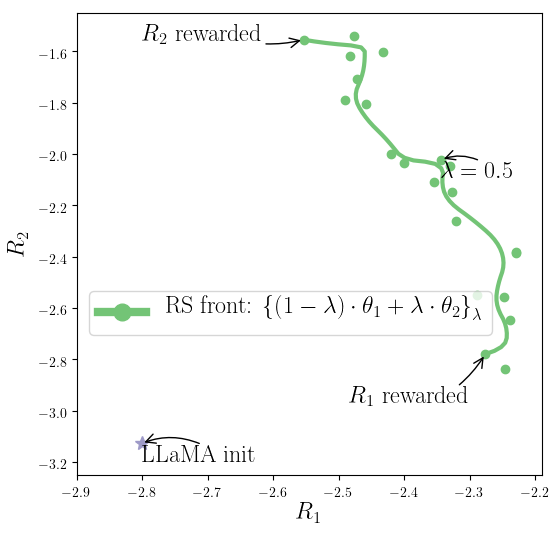

In [17]:
label_x = "R_1"
label_y = "R_2"
label_xy = "R_1+R_2"
labels = [
    r"RL: ${label_x}$".format(label_x=label_x),
    r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
    r"RL: ${label_y}$".format(label_y=label_y),
    r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
    r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
    # r"WA: $$ $\to$ ${label_y}$, $0\leq\lambda\leq1$".format(label_x=label_x, label_y=label_y)
    # r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)
    # r"RS: $(1-\lambda) \cdot \theta_{1} + \lambda \cdot \theta_{2}$"
            r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{\lambda}$",
]

plot.MULTIPLYLEGENDMARKER = 2
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_lv],
    key_x="hfl",
    key_y="hfd",
    _dict_key_to_limit={
        "hfd": [-3.25, -1.45],
        "hfl": [-2.9, -2.19]
    },
    labels=labels,
    # dic_key_to_label={"hfl": r"RL: $R_3$"},
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    list_indexes=[5],
    # do_annotate=True,
    # loc="lower left",
    loc=(0.0, 0.35),
    do_annotate="nomorl",
    dict_annotation_to_loc={
        # "pt": (-1.25, -2.4),
        "0": (-2.3, -3.),
        "1": (-2.8, -1.5),
        # "pt": (-2.7, -3.05),
        # "lambda": (-2.32, -1.8),
        "01": (-2.6, -2.4),
    },
    # connect_endpoints=True
)

arrowprops.update({"relpos": (0.5, 1)})
plot.plt.plot(
    modules_assistant_lv[0].l[0]["hfl"],
    modules_assistant_lv[0].l[0]["hfd"],
    marker="*",
    color=plot.get_color_from_cmap("Purples", dict_colormaps),
    markersize=10
)


plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hflvtohfd_simple.pdf", do_save=do_save)


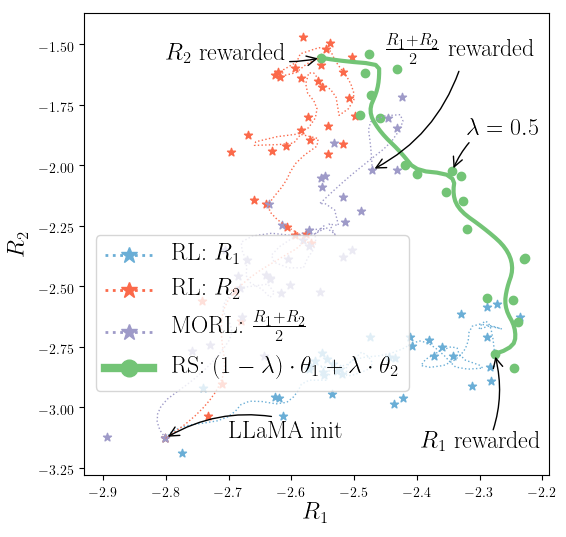

In [12]:
label_x = "R_1"
label_y = "R_2"
label_xy = "R_1+R_2"
labels = [
    r"RL: ${label_x}$".format(label_x=label_x),
    r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
    r"RL: ${label_y}$".format(label_y=label_y),
    r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
    r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
    # r"WA: $$ $\to$ ${label_y}$, $0\leq\lambda\leq1$".format(label_x=label_x, label_y=label_y)
    # r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)
    r"RS: $(1-\lambda) \cdot \theta_{1} + \lambda \cdot \theta_{2}$"
]

plot.MULTIPLYLEGENDMARKER = 2
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_lv],
    key_x="hfl",
    key_y="hfd",
    labels=labels,
    # dic_key_to_label={"hfl": r"RL: $R_3$"},
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    list_indexes=[0, 2, 4, 5],
    # do_annotate=True,
    # loc="lower left",
    loc=(0.0, 0.35),
    do_annotate=True,
    # _dict_key_to_limit={"hfd": [-3.5, -1.3]},
    dict_annotation_to_loc={
        # "pt": (-1.25, -2.4),
        "0": (-2.2, -3.2),
        "1": (-2.8, -1.5),
        "pt": (-2.7, -3.05),
        "lambda": (-2.32, -1.8),
        "01": (-2.45, -1.6),
    },
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hflvtohfd.pdf", do_save=do_save)


In [ ]:
plot.MULTIPLYLEGENDMARKER = 2
label_x = "R_3"
label_y = "R_2"
label_xy = "R_3+R_2"
labels = [
        r"RL: ${label_x}$".format(label_x=label_x),
        r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
        r"RL: ${label_y}$".format(label_y=label_y),
        r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
        r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
        # r"WA: $$ $\to$ ${label_y}$, $0\leq\lambda\leq1$".format(label_x=label_x, label_y=label_y)
        # r"RS: $(1-\lambda) \theta_{{{label_x}}} + \lambda \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)
        r"RS: $(1-\lambda) \cdot \theta_{3} + \lambda \cdot \theta_{2}$"
    ]

plot.MULTIPLYLEGENDMARKER = 2
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_bv],
    key_x="hfbv",
    key_y="hfd",
    labels=labels,
    # dic_key_to_label={"hfl": r"RL: $R_3$"},
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    list_indexes=[0, 2, 4, 5],
    # do_annotate=True,
    loc="lower right",
    do_annotate=True,
    order="savgol_5_1_slinear",
    _dict_key_to_limit={"hfd": [-3.5, -1.3]},
    dict_annotation_to_loc={
        "pt": (-1.2, -2.4),
        "0": (-0.55, -2.5),
        "1": (-1.2, -1.5),
        "lambda": (-0.56, -1.84),
        "01": (-0.68, -1.6),
    },
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hfbvtohfd.pdf", do_save=do_save)


In [ ]:
dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

num_colors = len(modules_multi_assistant) - 2
colors = [
    plot.cm.get_cmap(cmap_redpurpleblue)((num_colors - 1 - i) / (num_colors - 1))
    for i in range(num_colors)
]
colors += ["gold"]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]

fig_dr = plot_key_nlp(
    [module.l for module in modules_multi_assistant],
    labels=[module.label for module in modules_multi_assistant],
    colors=colors,
    colormaps=None,
    linestyles=([
        "dotted",
        "dashdot",
        "dashed",
    ] * num_colors)[:num_colors] + ["solid", "solid"],
    linewidths=([1] * num_colors) + [2, 3],
    key_x="hfbv",
    key_y="hfd",
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    # do_annotate=True,
    dict_annotation_to_loc={
        # "pt": (1.15, -1.8),
        # "0": (-0.25, -2.75),
        # "1": (-1.1, -1.5),
        # "lambda": (-0.35, -2),
        # "01": (-0.55, -1.72),
    },
    loc=(1.05, 0,),
    # order="connect",
    # legendtitle="Strategies:",
    list_indexes=None,
    do_annotate=False,
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hfbvtohfd_multimu.pdf", do_save=do_save)


In [ ]:


fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_bv],
    # labels=[module.label for module in modules_assistant_bv],
    key_x="hfbv",
    key_y="hfd",
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    do_annotate=True,
    loc="lower right",
    order="savgol_5_1_slinear",
    _dict_key_to_limit={"hfd": [-3.5, -1.3]},
    dict_annotation_to_loc={
        "pt": (-1.25, -2.4),
        "0": (-0.25, -2.7),
        "1": (-1.2, -1.5),
        "lambda": (-0.37, -1.8),
        "01": (-0.65, -1.6),
    },
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hfbvtohfd_main.pdf", do_save=do_save)


In [ ]:
plot.MULTIPLYLEGENDMARKER = 2
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_bl],
    key_x="hfbv",
    key_y="hfl",
    # list_indexes=None,
    # loc="lower right",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    list_indexes=[0, 2, 5],
    # do_annotate=True,
    loc="lower right",
    do_annotate=False,
    # _dict_key_to_limit={"hfd": [-3.5, -1.3]},
    # dict_annotation_to_loc={
    #     "pt": (-1.25, -2.4),
    #     "0": (-0.25, -2.7),
    #     "1": (-1.2, -1.5),
    #     "lambda": (-0.37, -1.95),
    #     "01": (-0.55, -1.7),
    # },
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_hflvtohbv_main.pdf", do_save=do_save)


In [ ]:
dict_colormaps = plot.create_colormaps()
colors=[
    plot.get_color_from_cmap("Blues", dict_colormaps),
    plot.get_color_from_cmap("Dark_Blues", dict_colormaps),
    plot.get_color_from_cmap("Reds", dict_colormaps),
    plot.get_color_from_cmap("Oranges", dict_colormaps),
]

fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_spider],
    labels=[module.label for module in modules_assistant_spider],
    # labels=[module.label for module in modules_assistant_bv],
    list_indexes=[0, 1, 2, 3],
    colors=colors,
    key_x="hfb",
    key_y="hfl",
    # list_indexes=None,
    markers=[ 'v', '^', '<', '>',],
    loc="upper left",
    # order="3",
    # keysize="lambda",
    # fontsize="x-small",
    do_annotate=False,
    dict_annotation_to_loc={
        # "pt": (1.15, -1.8),
        "0": (-0.25, -2.75),
        "1": (-1.1, -1.5),
        "lambda": (-0.35, -2),
        "01": (-0.55, -1.72),
    },
    fontsize="medium",
    order="connect",
    connect_endpoints=False
)


In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_assistant_bv_tmp],
#     labels=[module.label for module in modules_assistant_bv_tmp],
#     colors=["red", "pink", "blue", "yellow", "purple", "green", "grey"],
#     colormaps=None,
#     key_x="hfbv",
#     key_y="hfd",
#     list_indexes=None,
#     loc="lower right",
#     # order="3",
#     # keysize="lambda",
#     fontsize="x-small",
#     do_annotate=False,
#     # connect_endpoints=True
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_kl2.pdf", do_save=do_save)


In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_assistant_kl2_1000],
#     labels=[module.label for module in modules_assistant_kl2_1000],
#     # colors=["red", "pink", "blue", "yellow", "purple", "green"],
#     key_x="hfbv",
#     key_y="hfd",
#     list_indexes=[0, 2, 4, 5],
#     loc="lower right",
#     order="connect",
#     # keysize="lambda",
#     fontsize="x-small",
#     do_annotate=False,
#     # connect_endpoints=True
# )
# # plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_kl2.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_assistant_spider],
    labels=[module.label for module in modules_assistant_spider],
    colors=["red", "pink", "blue", "yellow", "purple", "green"],
    list_indexes=None,
    key_x="hfbv",
    key_y="hfd",
    loc="lower right",
    # order="connect",
    keysize="lambda",
    fontsize="x-small",
    do_annotate=False,
    # connect_endpoints=True
)
# plot.save_fig(fig=fig_dr, name="nlp/spider_assistant.pdf", do_save=do_save)


In [ ]:
# Llama assistant with kL


In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/nlp/llamaassistant/")


In [ ]:
from llamaassistant import logs_assistant_d_kl_steps, logs_assistant_d_kl_steps, logs_assistant_d_steps, logs_assistant_bd_wa, logs_assistant_wainittodkl, logs_assistant_bkl_steps_0406, logs_assistant_multikl_steps_0406, logs_assistant_wainittobkl_0406, logs_assistant_wabkltodkl_0410, logs_assistantsteps_hfb_kl005_fmulti_normallr, logs_assistantsteps_hfb_kl005_fmulti, logs_assistantsteps_hfd_kl005_fmulti_normallr, logs_assistantsteps_hfd_kl005_fmulti, logs_assistant_bkl_steps_jz, infassistant_rmdvbv_steps_0416, infassistant_bkl_frommultiklv3_steps_0406, infassistant_warmeld181rmdvlv231_0416, infassistant_warmeld221rmdvlv141_0416, infassistant_warmeld221rmdvbv161_0416, infassistant_warmeld81rmdvlv91_0416, infassistant_warmeld81rmdvbv161_0416
from llamaassistant import logs_assistant_bkl_steps_0406, logs_assistant_d_kl_steps, logs_assistant_wainittodkl, logs_assistant_multikl_steps_0406, logs_assistant_bkl_steps_jz, logs_assistant_rmdvlv_steps_0416, logs_assistant_dkl_steps_0416


In [ ]:
for key in logs_assistant_d_kl_steps.d.keys():
    assert key in logs_assistant_dkl_steps_0416.d
    logs_assistant_d_kl_steps.d[key] = [
        logs_assistant_d_kl_steps.d[key][0], logs_assistant_d_kl_steps.d[key][1],
        logs_assistant_d_kl_steps.d[key][2], logs_assistant_dkl_steps_0416.d[key][1],
        logs_assistant_dkl_steps_0416.d[key][0]
    ]
modules_xx = [logs_assistant_d_kl_steps]
modules_multi = [logs_assistant_multikl_steps_0406, infassistant_bkl_frommultiklv3_steps_0406]





modules_lvd = [
    logs_assistant_rmdvlv_steps_0416,
    EmptyModule(),
    logs_assistant_d_kl_steps,
    EmptyModule(),
    infassistant_warmeld81rmdvlv91_0416, infassistant_warmeld221rmdvlv141_0416]
# infassistant_warmeld181rmdvlv231_0416

modules_bvd = [
    infassistant_rmdvbv_steps_0416,
    EmptyModule(),
    logs_assistant_d_kl_steps,
    EmptyModule(),
    infassistant_warmeld221rmdvbv161_0416,
    infassistant_warmeld81rmdvbv161_0416
]

modules_bd = [
    # logs_assistant_bkl_steps_0406,
    logs_assistant_b_steps,
        EmptyModule(),
    # logs_assistant_d_kl_steps,
    logs_assistant_d_steps,
        EmptyModule(),
    logs_assistant_multikl_steps_0406,
    EmptyModule()
]
for modules in [modules_multi, modules_xx, modules_bd, modules_bvd, modules_lvd]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["hfl"] = module.d[key][0]["LABEL_0"]
                new_d["hfb"] = module.d[key][1]["REWARD"]
                new_d["hfd"] = module.d[key][2]["REWARD"]
                if "LABEL_0" in module.d[key][3]:
                    new_d["hfbv"] = module.d[key][3]["LABEL_0"]
                else:
                    new_d["hfbv"] = 0
                if len(module.d[key]) > 4 and "LABEL_0" in module.d[key][4]:
                    new_d["dvxr"] = module.d[key][4]["LABEL_0"]
                module.l.append(new_d)

# logs_assistant_d_kl_steps.l = [line for line in logs_assistant_d_kl_steps.l if line["lambda"] < 0.2834890965732087]
# logs_assistant_rmdvlv_steps_0416.l = [line for line in logs_assistant_rmdvlv_steps_0416.l if line["lambda"] < 1 + 0.578544061302682]
# infassistant_rmdvbv_steps_0416.l = [line for line in infassistant_rmdvbv_steps_0416.l if line["lambda"] < 0.5166163141993958]


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_bvd],
    key_x="hfbv",
    key_y="hfd",
    loc="upper left",
    # order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_bvtod.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_lvd],
    key_x="hfl",
    key_y="hfb",
    loc="upper left",
    # order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_lvtod.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_bd],
    labels=[module.label for module in modules_bd],
    key_x="hfb",
    key_y="hfd",
    loc="upper left",
    order="connect",
    do_annotate=False
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_assistant_btod.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_xx],
    labels=[module.label for module in modules_xx],
    key_x="dvxr",
    key_y="hfbv",
    loc="upper left",
    do_annotate=False
)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_multi],
    labels=[module.label for module in modules_multi],
    colors=["purple", "blue"],
    key_x="hfb",
    key_y="hfd",
    # loc="upper left",
    do_annotate=False
)


# Llama Summary news

In [8]:
from llamasummarynews import logs_summarynew_alpaca_tristan, logs_summarynew_alpaca_cog, logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_tristan_cog, logs_summarynew_multi, logs_snew_multi_cog, logs_snew_multi_tristan, infnews_cog_tristan_0406_step50, logs_summarynew_multi_step50, logs_summarynew_tristan_cog_step90
from llamasummarynews.multi import infnews_multi123_0426
# steps 101


In [9]:
from llamasummarynews import logs_summarynews_quality


In [10]:
# % |        | MORL  | MORL  | RS    | RS    |
# % |--------|-------|-------|-------|-------|
# % | Length | 32    | 64    | 32    | 64    |
# % | $R_1$  | 1.31  | 1.27  | 1.45  | 1.47  |
# % | $R_2$  | -1.00 | -0.95 | -1.11 | -1.03 |

bs64_wa = {}
bs64_wa[ 0 ] = [{'LABEL_0': 0.9817439719289541, 'n': 'grs'}, {'HALLUCINATED': 0.35493750892579556, 'FAITHFUL': -0.4441463256813586, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.1 ] = [{'LABEL_0': 1.097799543365836, 'n': 'grs'}, {'HALLUCINATED': 0.3553891997039318, 'FAITHFUL': -0.4437603666819632, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.2 ] = [{'LABEL_0': 1.1955975046008824, 'n': 'grs'}, {'HALLUCINATED': 0.37247000355273484, 'FAITHFUL': -0.439684436339885, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.3 ] = [{'LABEL_0': 1.2668140196055173, 'n': 'grs'}, {'HALLUCINATED': 0.3817191475955769, 'FAITHFUL': -0.4443116354756057, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.4 ] = [{'LABEL_0': 1.3852596275135876, 'n': 'grs'}, {'HALLUCINATED': 0.4620999762043357, 'FAITHFUL': -0.45919137962162493, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.5 ] = [{'LABEL_0': 1.4644523555785418, 'n': 'grs'}, {'HALLUCINATED': 0.5427665299922228, 'FAITHFUL': -0.46073050301522017, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.6 ] = [{'LABEL_0': 1.5325884484499692, 'n': 'grs'}, {'HALLUCINATED': 0.5524653424695134, 'FAITHFUL': -0.45890614490956066, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.7 ] = [{'LABEL_0': 1.6043897141329944, 'n': 'grs'}, {'HALLUCINATED': 0.5901654633134603, 'FAITHFUL': -0.4609741941466928, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.8 ] = [{'LABEL_0': 1.7226528556458651, 'n': 'grs'}, {'HALLUCINATED': 0.6526767714647577, 'FAITHFUL': -0.4654464489594102, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 0.9 ] = [{'LABEL_0': 1.7718524332158267, 'n': 'grs'}, {'HALLUCINATED': 0.7189775269990787, 'FAITHFUL': -0.4695687463693321, 'n': 'bfsd'}, {'length': 200}]
bs64_wa[ 1 ] = [{'LABEL_0': 1.8477796719968318, 'n': 'grs'}, {'HALLUCINATED': 0.7107725292863324, 'FAITHFUL': -0.4684581663645804, 'n': 'bfsd'}, {'length': 200}]

bs_morl = {}
bs_morl[ 1 ] = [{'LABEL_0': 0.9817439719289541, 'n': 'grs'}, {'HALLUCINATED': 0.35493750892579556, 'FAITHFUL': -0.4441463256813586, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.9 ] = [{'LABEL_0': 0.9461970641836523, 'n': 'grs'}, {'HALLUCINATED': 0.5651239268109203, 'FAITHFUL': -0.457498529907316, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.8 ] = [{'LABEL_0': 1.0928484796360136, 'n': 'grs'}, {'HALLUCINATED': 0.35117306496948003, 'FAITHFUL': -0.443059711586684, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.7 ] = [{'LABEL_0': 1.09641533179022371, 'n': 'grs'}, {'HALLUCINATED': 0.5774698721943423, 'FAITHFUL': -0.45713797589764, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.6 ] = [{'LABEL_0': 1.2617642009630798, 'n': 'grs'}, {'HALLUCINATED': 0.34305383685976265, 'FAITHFUL': -0.44400817980989815, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.5 ] = [{'LABEL_0': 1.2750379442051054, 'n': 'grs'}, {'HALLUCINATED': 0.4978780897660181, 'FAITHFUL': -0.4531287966109812, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.4 ] = [{'LABEL_0': 1.5033470475673676, 'n': 'grs'}, {'HALLUCINATED': 0.3896370244026184, 'FAITHFUL': -0.44680441489443184, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.3 ] = [{'LABEL_0': 1.5851280780509114, 'n': 'grs'}, {'HALLUCINATED': 0.5779653694061563, 'FAITHFUL': -0.4597723734751344, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.2 ] = [{'LABEL_0': 1.5677181788906456, 'n': 'grs'}, {'HALLUCINATED': 0.483236353667744, 'FAITHFUL': -0.4528133811429143, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0.1 ] = [{'LABEL_0': 1.7600371342897416, 'n': 'grs'}, {'HALLUCINATED': 0.7303584061842412, 'FAITHFUL': -0.4711098108626902, 'n': 'bfsd'}, {'length': 200}]
bs_morl[ 0 ] = [{'LABEL_0': 1.8477796719968318, 'n': 'grs'}, {'HALLUCINATED': 0.7107725292863324, 'FAITHFUL': -0.4684581663645804, 'n': 'bfsd'}, {'length': 200}]


In [11]:
modules_multi = [
    FakeModule(
        d=d,
        label=label)
    for d, label in zip(infnews_multi123_0426.ds, infnews_multi123_0426.labels)
]

modules_64 = [FakeModule(d=d, label=label) for label, d in enumerate([bs64_wa, bs_morl])]

modules_multi = [logs_summarynew_tristan_steps] + modules_multi + [logs_summarynew_cog_steps]
l_multi = FakeModule(
    d={i: (module.d[2] if 2 in module.d else module.d[1])
       for i, module in enumerate(modules_multi)}, label="multi", add0=False
)
modules_multi_full = modules_multi + [l_multi, logs_summarynew_tristan_cog_step90]

modules_multi_clean = [logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_multi, l_multi, logs_summarynew_tristan_cog_step90]


In [12]:
# modules_summary_news
# modules_summary_news_step50
for modules in [modules_64, modules_multi, modules_multi_full]:
    for module in modules:
        if isinstance(module, EmptyModule):
            continue
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[2:-1])
        for key in sorted(module.d.keys()):
            if True:
                new_d = {"lambda": key}
                new_d["tristan"] = module.d[key][0]["LABEL_0"]
                new_d["cogd"] = module.d[key][1]["FAITHFUL"] - module.d[key][1]["HALLUCINATED"]
                new_d["cogfaithful"] = module.d[key][1]["FAITHFUL"]
                if len(module.d[key]) > 2 and "good" in module.d[key][2]:
                    new_d["quality"] = module.d[key][2]["good"]
                if len(module.d[key]) > 2 and "mlms" in module.d[key][2]:
                    new_d["mlms"] = module.d[key][2]["mlms"]
                if len(module.d[key]) > 3 and "gpt" in module.d[key][3]:
                    new_d["gpt"] = module.d[key][3]["gpt"]
                module.l.append(new_d)

# logs_summarynew_tristan_steps.l = [line for line in logs_summarynew_tristan_steps.l if line["lambda"] < 0.6273291925465838]


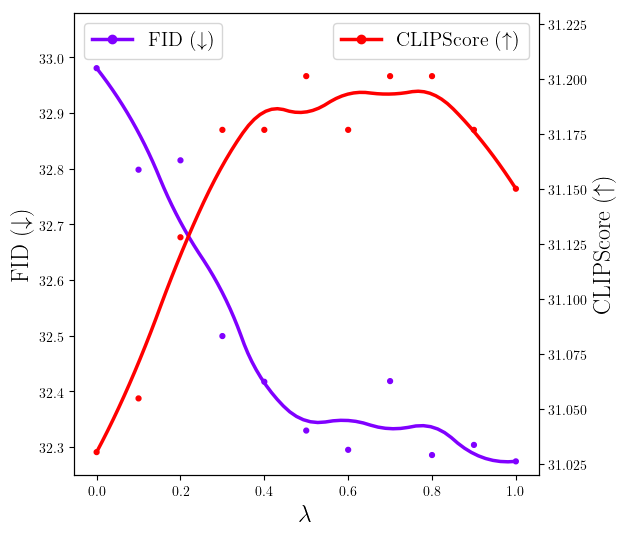

In [43]:
wa_clipscores = [
31.0302734375,
31.0546875,
31.1279296875,
31.1767578125,
31.1767578125,
31.201171875,
31.1767578125,
31.201171875,
31.201171875,
31.1767578125,
31.15]

wa_fids = [32.98038970826519,
32.797969765504035,
32.81482540697198,
32.49910976347485,
32.41697886978454,
32.329336817425144,
32.29473548750411,
32.418189109406455,
32.28535342711638,
32.30355877245171,
        32.274]

ldiffusion = [
    {
        "lambda": i / 10,
        "FID": wa_fids[i],
        "CLIPScore": wa_clipscores[i],
    } for i in range(0, 11)
]

fig_dr = plot.plot_basic_scatter(
    ldiffusion,
    key_x="lambda",
    keys_y=["FID", "CLIPScore"],
    keys_y_2=["CLIPScore"],
    _dict_key_to_label={
        "FID": r"FID ($\downarrow$)",
        "CLIPScore": r"CLIPScore ($\uparrow$)"
    },
    y_axis_name=r"FID ($\downarrow$)",
    y2_axis_name=r"CLIPScore ($\uparrow$)",
    order="savgol_3_1_quadratic",
    loc="upper left",
    _dict_key_to_limit={"y": [32.25, 33.08], "y2": [31.02, 31.23]},
)

plot.save_fig(fig=fig_dr, name="nlp/diffusionquality.pdf", do_save=do_save)


In [ ]:
#


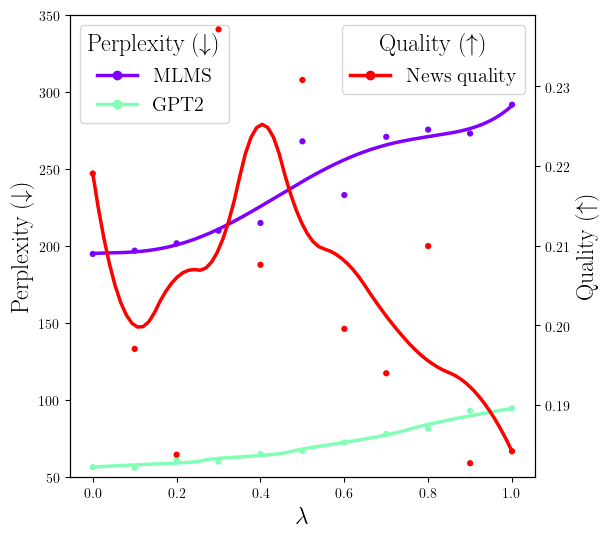

In [9]:
new_data = {}
new_data[ 0 ] = [{'LABEL_0': 0.980100826844573, 'n': 'grs'}, {'HALLUCINATED': 0.35395207181572913, 'FAITHFUL': -0.4441262733377516, 'n': 'bfsd'}, {'mlms': 291.5893833297491, 'n': 'rt'}, {'length': 200}]
new_data[ 0.1 ] = [{'LABEL_0': 1.0969557078927756, 'n': 'grs'}, {'HALLUCINATED': 0.36301875934004785, 'FAITHFUL': -0.4442241486348212, 'n': 'bfsd'}, {'mlms': 272.8853210809543, 'n': 'rt'}, {'length': 200}]
new_data[ 0.2 ] = [{'LABEL_0': 1.1911249472945928, 'n': 'grs'}, {'HALLUCINATED': 0.34843603033572434, 'FAITHFUL': -0.44370206849649546, 'n': 'bfsd'}, {'mlms': 275.37402633016075, 'n': 'rt'}, {'length': 200}]
new_data[ 0.3 ] = [{'LABEL_0': 1.2618874114006757, 'n': 'grs'}, {'HALLUCINATED': 0.3864083399577066, 'FAITHFUL': -0.4468122642301023, 'n': 'bfsd'}, {'mlms': 270.7186542570078, 'n': 'rt'}, {'length': 200}]
new_data[ 0.4 ] = [{'LABEL_0': 1.374935951642692, 'n': 'grs'}, {'HALLUCINATED': 0.5690656546875834, 'FAITHFUL': -0.4599070949852467, 'n': 'bfsd'}, {'mlms': 232.8952194004519, 'n': 'rt'}, {'length': 200}]
new_data[ 0.5 ] = [{'LABEL_0': 1.452224769666791, 'n': 'grs'}, {'HALLUCINATED': 0.6480042544752359, 'FAITHFUL': -0.46481697652488946, 'n': 'bfsd'}, {'mlms': 267.78632408733034, 'n': 'rt'}, {'length': 200}]
new_data[ 0.6 ] = [{'LABEL_0': 1.5083751826733351, 'n': 'grs'}, {'HALLUCINATED': 0.6552921738475561, 'FAITHFUL': -0.4647320870682597, 'n': 'bfsd'}, {'mlms': 214.77549997253485, 'n': 'rt'}, {'length': 200}]
new_data[ 0.7 ] = [{'LABEL_0': 1.5806728337518872, 'n': 'grs'}, {'HALLUCINATED': 0.682115140389651, 'FAITHFUL': -0.4660321443900466, 'n': 'bfsd'}, {'mlms': 209.745290229285, 'n': 'rt'}, {'length': 200}]
new_data[ 0.8 ] = [{'LABEL_0': 1.678518992792815, 'n': 'grs'}, {'HALLUCINATED': 0.7917981202900409, 'FAITHFUL': -0.4754679702594876, 'n': 'bfsd'}, {'mlms': 201.55392773340245, 'n': 'rt'}, {'length': 200}]
new_data[ 0.9 ] = [{'LABEL_0': 1.7243770389072597, 'n': 'grs'}, {'HALLUCINATED': 0.9285845712386072, 'FAITHFUL': -0.48389775639399885, 'n': 'bfsd'}, {'mlms': 196.80306500092726, 'n': 'rt'}, {'length': 200}]
new_data[ 1 ] = [{'LABEL_0': 1.7681593088805676, 'n': 'grs'}, {'HALLUCINATED': 0.9732655213354156, 'FAITHFUL': -0.48571501022204755, 'n': 'bfsd'}, {'mlms': 194.63380619879766, 'n': 'rt'}, {'length': 200}]

new_data[ 0 ].append(94.4197)
new_data[ 0.1 ].append(92.7984)
new_data[ 0.2 ].append(81.3316)
new_data[ 0.3 ].append(77.7548)
new_data[ 0.4 ].append(72.2908)
new_data[ 0.5 ].append(66.7772)
new_data[ 0.6 ].append(64.7648)
new_data[ 0.7 ].append(59.7886)
new_data[ 0.8 ].append(61.0976)
new_data[ 0.9 ].append(55.7301)
new_data[ 1 ].append(56.2075)



for l in logs_summarynews_quality.l:
    l["mlms"] = new_data[l["lambda"]][2]["mlms"]
    l["gpt"] = new_data[l["lambda"]][-1]

fig_dr = plot.plot_basic_scatter(
    logs_summarynews_quality.l,
    key_x="1-lambda",
    keys_y=["mlms", "gpt", "quality"],
    keys_y_2=["quality"],
    _dict_key_to_label={
        "mlms": r"MLMS",
        "gpt": r"GPT2",
        "quality": r"News quality"
    },
    legendtitle=[r"Perplexity ($\downarrow$)", r"Quality ($\uparrow$)"],
    y_axis_name=r"Perplexity ($\downarrow$)",
    y2_axis_name=r"Quality ($\uparrow$)",
    order="savgol_3_1_quadratic",
    loc="upper left",
    _dict_key_to_limit={
        "y": [50, 350],
        "y2": [0.181, 0.239]
    },
)

plot.save_fig(
    fig=fig_dr,
    name="nlp/textquality.pdf",
    do_save=do_save
)


In [ ]:
 import matplotlib as mpl

 mpl.rc('image', origin='upper')

# #  mpl.rc('text', usetex=True)
 DefaultProps = mpl.font_manager.FontProperties(family = "sans-serif",\
                                                 style = "normal",\
                                                 weight = "medium",\
                                                 size = 6)


In [18]:
modules_64[0].d


{1: [{'LABEL_0': 0.9817439719289541, 'n': 'grs'},
  {'HALLUCINATED': 0.35493750892579556,
   'FAITHFUL': -0.4441463256813586,
   'n': 'bfsd'},
  {'length': 200}],
 0.9: [{'LABEL_0': 0.9461970641836523, 'n': 'grs'},
  {'HALLUCINATED': 0.5651239268109203,
   'FAITHFUL': -0.457498529907316,
   'n': 'bfsd'},
  {'length': 200}],
 0.8: [{'LABEL_0': 1.0928484796360136, 'n': 'grs'},
  {'HALLUCINATED': 0.35117306496948003,
   'FAITHFUL': -0.443059711586684,
   'n': 'bfsd'},
  {'length': 200}],
 0.7: [{'LABEL_0': 1.0964153317902237, 'n': 'grs'},
  {'HALLUCINATED': 0.5774698721943423,
   'FAITHFUL': -0.45713797589764,
   'n': 'bfsd'},
  {'length': 200}],
 0.6: [{'LABEL_0': 1.2617642009630798, 'n': 'grs'},
  {'HALLUCINATED': 0.34305383685976265,
   'FAITHFUL': -0.44400817980989815,
   'n': 'bfsd'},
  {'length': 200}],
 0.5: [{'LABEL_0': 1.2750379442051054, 'n': 'grs'},
  {'HALLUCINATED': 0.4978780897660181,
   'FAITHFUL': -0.4531287966109812,
   'n': 'bfsd'},
  {'length': 200}],
 0.4: [{'LABEL_0':

Failed for label: None because: If mode is 'interp', window_length must be less than or equal to the size of x.


/Users/alexandrerame/code_repository/codedev/domainbedv2/domainbed/codeplot/plot.py:999: RankWarning: Polyfit may be poorly conditioned
  linestyle=linestyle


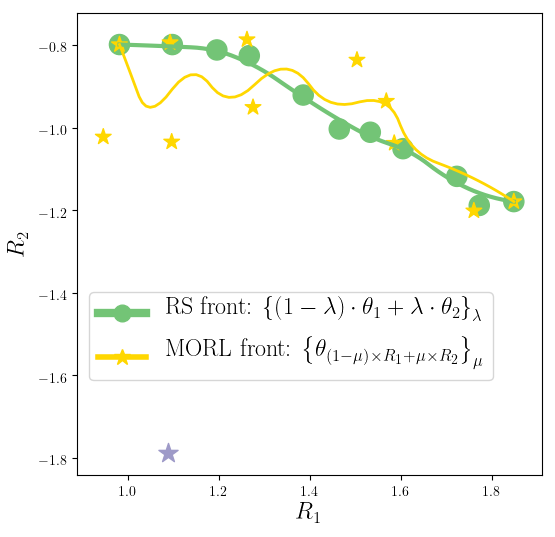

In [45]:
dict_colormaps = plot.create_colormaps()

colors = [
        # plot.get_color_from_cmap("Reds", dict_colormaps),
        # plot.get_color_from_cmap("Purples", dict_colormaps),
        # plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
colors += [plot.get_color_from_cmap("Purples", dict_colormaps)]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]
colors += ["gold"]

key_x = "tristan"
key_y = "cogd"

SIZE_MAIN = "xx-large"
# modules_multi_clean = [logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_multi, l_multi, logs_summarynew_tristan_cog_step90]

fig_dr = plot_key_nlp(
    [logs_summarynew_tristan_steps.l[:1]] +
    [module.l for module in modules_64],
    labels=[
        None,
        # r"RL: $R_1$",
        # r"RL: $R_2$",
        # r"MORL: $\frac{R_1 + R_2}{2}$",
        r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{\lambda}$",
        r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{\mu}$",
        # r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{0\leq \lambda \leq 1}$",
        # r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{0\leq \mu \leq 1}$",
    ],
    colors=colors,
    colormaps=None,
    do_annotate=False,
    linestyles=[
        "dotted",
        # "dotted",
        # "dotted",
    ] + ["solid", "solid*"],
    markersizes=[210, 210, 140,],
    linewidths=[
        1,
        # 1,1,
        3,
        2
    ],
    key_x="tristan",
    key_y="cogd",
    loc=(0., 0.3),
    list_indexes=[0, 1, 2],
    # order="1",
    fontsize="xx-large",
    dict_annotation_to_loc={},
    # _dict_key_to_limit={
    #     "tristan": (0.82, 1.82)
    # }
)


plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_multimu_simple_nomorl_64.pdf", do_save=do_save)


Failed for label: None because: If mode is 'interp', window_length must be less than or equal to the size of x.


/Users/alexandrerame/code_repository/codedev/domainbedv2/domainbed/codeplot/plot.py:999: RankWarning: Polyfit may be poorly conditioned
  linestyle=linestyle


Text(1.55, -1.75, '\\begin{center}$R_1$ rewarded\\\\($\\lambda=0$)\\end{center}')

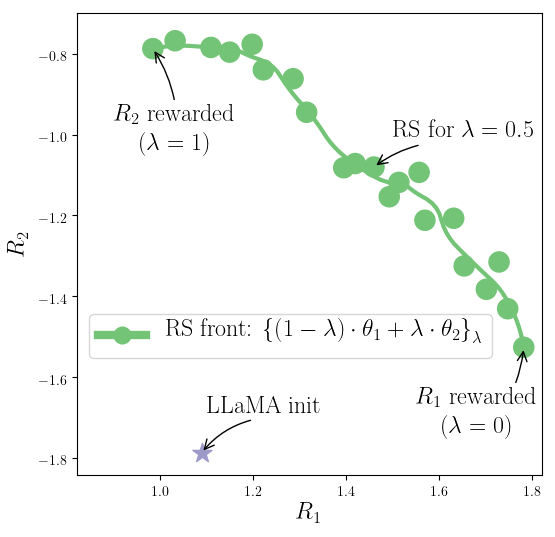

Failed for label: None because: If mode is 'interp', window_length must be less than or equal to the size of x.


/Users/alexandrerame/code_repository/codedev/domainbedv2/domainbed/codeplot/plot.py:999: RankWarning: Polyfit may be poorly conditioned
  linestyle=linestyle


Text(1.55, -1.75, '\\begin{center}$R_1$ rewarded\\\\($\\lambda=0$)\\end{center}')

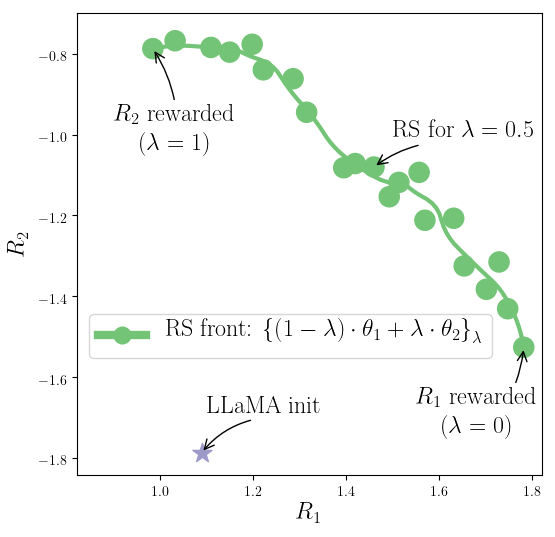

In [15]:
dict_colormaps = plot.create_colormaps()

colors = [
        # plot.get_color_from_cmap("Reds", dict_colormaps),
        # plot.get_color_from_cmap("Purples", dict_colormaps),
        # plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
colors += [plot.get_color_from_cmap("Purples", dict_colormaps)]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]
colors += ["gold"]

key_x = "tristan"
key_y = "cogd"

SIZE_MAIN = "xx-large"
# modules_multi_clean = [logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_multi, l_multi, logs_summarynew_tristan_cog_step90]

fig_dr = plot_key_nlp(
    [logs_summarynew_tristan_steps.l[:1]] +
    [module.l for module in [logs_summarynew_tristan_cog_step90, l_multi]],
    labels=[
        None,
        # r"RL: $R_1$",
        # r"RL: $R_2$",
        # r"MORL: $\frac{R_1 + R_2}{2}$",
        r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{\lambda}$",
        r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{\mu}$",
        # r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{0\leq \lambda \leq 1}$",
        # r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{0\leq \mu \leq 1}$",
    ],
    colors=colors,
    colormaps=None,
    do_annotate=False,
    linestyles=[
        "dotted",
        # "dotted",
        # "dotted",
    ] + ["solid", "solid*"],
    markersizes=[210, 210, 140,],
    linewidths=[
        1,
        # 1,1,
        3,
        2
    ],
    key_x="tristan",
    key_y="cogd",
    loc=(0., 0.3),
    list_indexes=[0, 1],
    # order="connect",
    fontsize="xx-large",
    dict_annotation_to_loc={},
    _dict_key_to_limit={
        "tristan": (0.82, 1.82)
    }
)

arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.
plot.plt.annotate(
    r"LLaMA init",
    xy=(
        logs_summarynew_tristan_steps.l[0][key_x],
        logs_summarynew_tristan_steps.l[0][key_y]
    ),
    xytext=(
        1.1,
        -1.7
    ),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)


coeff = 0.
plot.plt.annotate(
    r"\begin{center}$R_2$ rewarded\\($\lambda=1$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(0.9, -1.05),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

coeff = 0.5
xytext8 = (
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_x] + 0.002,
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_y] - 0.1
)
plot.plt.annotate(
    r"\begin{center}RS for $\lambda=0.5$\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.5, -1.02),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

coeff = 1
plot.plt.annotate(
    r"\begin{center}$R_1$ rewarded\\($\lambda=0$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.55, -1.75),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_multimu_simple_nomorl.pdf", do_save=do_save)


In [11]:
dict_colormaps = plot.create_colormaps()

colors = [
        # plot.get_color_from_cmap("Reds", dict_colormaps),
        # plot.get_color_from_cmap("Purples", dict_colormaps),
        # plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
colors += [plot.get_color_from_cmap("Purples", dict_colormaps)]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]
colors += ["gold"]

key_x = "tristan"
key_y = "cogd"

SIZE_MAIN = "xx-large"
# modules_multi_clean = [logs_summarynew_tristan_steps, logs_summarynew_cog_steps, logs_summarynew_multi, l_multi, logs_summarynew_tristan_cog_step90]

fig_dr = plot_key_nlp(
    [logs_summarynew_tristan_steps.l[:1]] +
    [module.l for module in [logs_summarynew_tristan_cog_step90, l_multi]],
    labels=[
        None,
        # r"RL: $R_1$",
        # r"RL: $R_2$",
        # r"MORL: $\frac{R_1 + R_2}{2}$",
        r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{\lambda}$",
        r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{\mu}$",
        # r"RS front: $\left\{\left(1-\lambda\right) \cdot \theta_{1} + \lambda \cdot \theta_{2}\right\}_{0\leq \lambda \leq 1}$",
        # r"MORL front: $\left\{\theta_{\left(1-\mu\right) \times R_1 + \mu \times R_2}\right\}_{0\leq \mu \leq 1}$",
    ],
    colors=colors,
    colormaps=None,
    do_annotate=False,
    linestyles=[
        "dotted",
        # "dotted",
        # "dotted",
    ] + ["solid", "solid*"],
    markersizes=[210, 210, 140,],
    linewidths=[
        1,
        # 1,1,
        3,
        2
    ],
    key_x="tristan",
    key_y="cogd",
    loc=(0., 0.3),
    # order="connect",
    list_indexes=None,
    fontsize="xx-large",
    dict_annotation_to_loc={},
    _dict_key_to_limit={
        "tristan": (0.82, 1.82)
    }
)

arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.
plot.plt.annotate(
    r"LLaMA init",
    xy=(
        logs_summarynew_tristan_steps.l[0][key_x],
        logs_summarynew_tristan_steps.l[0][key_y]
    ),
    xytext=(
        1.1,
        -1.7
    ),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)


coeff = 0.
plot.plt.annotate(
    r"\begin{center}$R_2$ rewarded\\($\mu=\lambda=1$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(0.9, -1.05),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

coeff = 0.5
xytext8 = (
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_x] + 0.002,
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_y] - 0.1
)
plot.plt.annotate(
    r"\begin{center}RS for $\lambda=0.5$\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.5, -1.02),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)


plot.plt.annotate(
    # r"\begin{center}$\frac{R_1 + R_2}{2}$ rewarded\\($\mu=0.5$)\end{center}",
    r"\begin{center}MORL for $\mu=0.5$\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_multi.l,
                     coeff=1.0)[key_x], get_at_coeff(logs_summarynew_multi.l, coeff=1.0)[key_y]
    ),
    xytext=(1.34, -0.9),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

coeff = 1
plot.plt.annotate(
    r"\begin{center}$R_1$ rewarded\\($\mu=\lambda=0$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.55, -1.75),
    ha='left',
    va="bottom",
    size=SIZE_MAIN,
    arrowprops=arrowpropskey
)

# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_multimu_simple.pdf", do_save=do_save)


AttributeError: module 'llamasummarynews.logs_summarynew_tristan_steps' has no attribute 'l'

In [ ]:
plot.SIZE = "x-large"
plot.MULTIPLYLEGENDMARKER = 1
dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

num_colors = len(modules_multi_full) - 2
colors = [
    plot.cm.get_cmap(cmap_redpurpleblue)((num_colors - 1 - i) / (num_colors - 1))
    for i in range(num_colors)
]
colors += ["gold"]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]

key_x = "tristan"
key_y = "cogd"
fig_dr = plot_key_nlp(
    [module.l for module in modules_multi_full],
    labels=[
        r"RL $R_1$: $\mu=0.0$",
        r"MORL: $\mu=0.1$",
        r"MORL: $\mu=0.2$",
        r"MORL: $\mu=0.3$",
        r"MORL: $\mu=0.4$",
        r"MORL: $\mu=0.5$",
        r"MORL: $\mu=0.6$",
        r"MORL: $\mu=0.7$",
        r"MORL: $\mu=0.8$",
        r"MORL: $\mu=0.9$",
        r"RL $R_2$: $\mu=1.0$",
        r"MORL front",  #$(1-\mu) BLEU1$ $+$ $\mu ROUGE$",
        r"RS front",  # $(1-\lambda) \theta_{BLEU1} + \lambda \theta_{ROUGE}$"
    ],
    colors=colors,
    colormaps=None,
    do_annotate="onlypt",
    linestyles=([
        "dotted",
        "dashdot",
        "dashed",
    ] * num_colors)[:num_colors] + ["solid*", "solid"],
    linewidths=([1] * num_colors) + [2, 3],
    key_x="tristan",
    key_y="cogd",
    loc="lower left",
    # order="connect",
    # legendtitle="Strategies:",
    list_indexes=None,
    fontsize="large",
    dict_annotation_to_loc={
        "pt": (0.9, -1.8),
        # "0": (1.96, -1.6),
        # "1": (1.05, -0.7),
        # "lambda": (1.35, -1.25),
        # "01": (1.0, -1.2),
    },
    _dict_key_to_limit={
        "cogd": [-1.85, -0.75],
        "tristan": [0.25, 1.8]
    }
)

arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.
plot.plt.annotate(
    r"\begin{center}$R_2$ rewarded\\($\mu=\lambda=1.0$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(0.4, -0.91),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)


coeff = 0.1
plot.plt.annotate(
    r"$\lambda=0.9$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(
        0.5,
        -1.02
    ),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

coeff = 0.2
plot.plt.annotate(
    r"$\lambda=0.8$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(
        0.8,
        -1.02
    ),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.3
plot.plt.annotate(
    r"$\lambda=0.7$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.3, -0.81),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.4
plot.plt.annotate(
    r"$\lambda=0.6$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.3, -0.91),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.5
xytext8 = (
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_x] + 0.002,
    get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=0.8)[key_y] - 0.1
)
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.42, -1.01),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.6
plot.plt.annotate(
    r"$\lambda=0.4$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.42, -1.2),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.7
plot.plt.annotate(
    r"$\lambda=0.3$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.42, -1.35),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.8
plot.plt.annotate(
    r"$\lambda=0.2$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.42, -1.45),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 0.9
plot.plt.annotate(
    r"$\lambda=0.1$",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.42, -1.55),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 1
plot.plt.annotate(
    r"\begin{center}$R_1$ rewarded\\($\mu=\lambda=0.0$)\end{center}",
    xy=(
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_x],
        get_at_coeff(logs_summarynew_tristan_cog_step90.l, coeff=coeff)[key_y]
    ),
    xytext=(1.41, -1.84),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_multimu.pdf", do_save=do_save)
plot.SIZE = "xx-large"
plot.MULTIPLYLEGENDMARKER = 2


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_summary_news_step50],
    key_x="tristan",
    key_y="cogd",
    loc="upper right",
    # legendtitle="Strategies:",
    do_annotate=False,
    dict_annotation_to_loc={
        # "pt": (1.15, -1.8),
        # "0": (1.96, -1.6),
        # "1": (1.05, -0.7),
        # "lambda": (1.35, -1.25),
        # "01": (1.0, -1.2),
    },
    _dict_key_to_limit={
        "cogd": [-1.85, -0.65],
        "tristan": [0.85, 2.]
    }
)
#plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_main_step50.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_summary_news],
    key_x="tristan",
    key_y="cogd",
    loc="upper right",
    # legendtitle="Strategies:",
    dict_annotation_to_loc={
        "pt": (1.15, -1.8),
        "0": (1.96, -1.6),
        "1": (1.05, -0.7),
        "lambda": (1.35, -1.25),
        "01": (1.0, -1.2),
    },
    _dict_key_to_limit={
        "cogd": [-1.85, -0.65],
        "tristan": [0.85, 2.]
    }
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd_main.pdf", do_save=do_save)


In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_summary_news],
#     key_x="tristan",
#     key_y="cogd",
#     # loc="upper right",
#     # fontsize="medium",
#     dict_annotation_to_loc={
#         "pt": (1.15, -1.8),
#         "0": (1.7, -1.83),
#         "1": (1., -0.78),
#         "01": (1.35, -0.95),
#     },
# )
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summarynews_tristantocogd.pdf", do_save=do_save)


# Llama Summary

In [ ]:
from llamasummary import logs_tristan_cog_step20_v0, logs_tristan_cog_step40_kl005, logs_tristan_cog_step40, logs_tristan_cog_step30, logs_tristan_cog_step40_v0, logs_cogsoups_step40, logs_alpaca_cogsoups_step40, logs_alpaca_cog, logs_alpaca_cog_kl005, logs_tristan_cog_stepend, logs_alpaca_tristan_kl005, logs_multi_step40_200_kl005, logs_multitask_tristan_190_200, logs_multitask_cog_190_200, logs_cog_steps_200, logs_tristan_steps_200

from llamasummary.multi import llamasummary_multi64
from llamasummary.multimerged import snew_64, snew_28, snew_46, snew_82, snew_91, snew_19, snew_37, snew_73


In [ ]:
modules_summary = [
    logs_tristan_steps_200,
    logs_alpaca_tristan_kl005,
    logs_cog_steps_200,
    logs_alpaca_cog_kl005,
    logs_multi_step40_200_kl005,
    logs_tristan_cog_step40_kl005
    ]

modules_summary_multi = [
    logs_tristan_steps_200,
    logs_multi_step40_200_kl005,
    llamasummary_multi64,
    logs_cog_steps_200,
    logs_tristan_cog_step40_kl005
]
modules_multi_full_summary = [
    logs_tristan_steps_200,
    snew_19,
    snew_28, snew_46, snew_37,
    logs_multi_step40_200_kl005,
    snew_64,
    snew_73,
    snew_82,
    snew_91,
    logs_cog_steps_200,
]
l_multi = FakeModule(
    d={i: module.d[1] for i, module in enumerate(modules_multi_full_summary)},
    label="multi",
    add0=False
)

modules_multi_full_summary = modules_multi_full_summary + [l_multi, logs_tristan_cog_step40_kl005]


modules_summary_all = [
    logs_multitask_tristan_190_200,
    logs_multitask_cog_190_200
]


In [ ]:
logs_tristan_cog_step40_kl005.l


In [ ]:
for modules in [modules_summary, modules_summary_multi, modules_multi_full_summary]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["tristan"] = module.d[key][0]["LABEL_0"]
                new_d["cogd"] = module.d[key][1]["FAITHFUL"] - module.d[key][1]["HALLUCINATED"]
                new_d["cogfaithful"] = module.d[key][1]["FAITHFUL"]
                module.l.append(new_d)


In [ ]:
logs_tristan_cog_step40_kl005.l[::-1]


In [ ]:
dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)
plot.SIZE = "x-large"
plot.MULTIPLYLEGENDMARKER = 1
num_colors = len(modules_multi_full_summary) - 2
colors = [
    plot.cm.get_cmap(cmap_redpurpleblue)((num_colors - 1 - i) / (num_colors - 1))
    for i in range(num_colors)
]
colors += ["gold"]
colors += [plot.get_color_from_cmap("Greens", dict_colormaps)]
key_x = "tristan"
key_y = "cogd"
fig_dr = plot_key_nlp(
    [module.l for module in modules_multi_full_summary],
    labels=[
        r"RL $R_1$: $\mu=0.0$",
        r"MORL: $\mu=0.1$",
        r"MORL: $\mu=0.2$",
        r"MORL: $\mu=0.3$",
        r"MORL: $\mu=0.4$",
        r"MORL: $\mu=0.5$",
        r"MORL: $\mu=0.6$",
        r"MORL: $\mu=0.7$",
        r"MORL: $\mu=0.8$",
        r"MORL: $\mu=0.9$",
        r"RL $R_2$: $\mu=1.0$",
        r"MORL front",  #$(1-\mu) BLEU1$ $+$ $\mu ROUGE$",
        r"RS front",  # $(1-\lambda) \theta_{BLEU1} + \lambda \theta_{ROUGE}$"
    ],
    colors=colors,
    colormaps=None,
    linestyles=([
        "dotted",
        "dashdot",
        "dashed",
    ] * num_colors)[:num_colors] + ["solid*", "solid"],
    linewidths=([1] * num_colors) + [2, 3],
    key_x="tristan",
    key_y="cogd",
    loc="lower left",
    # order="connect",
    # legendtitle="Strategies:",
    list_indexes=None,
    fontsize="large",
    do_annotate="onlypt",
    dict_annotation_to_loc={
        "pt": (0.4, -0.2),
        # "0": (1.96, -1.6),
        # "1": (1.05, -0.7),
        # "lambda": (1.35, -1.25),
        # "01": (1.0, -1.2),
    },
    _dict_key_to_limit={
        "cogd": [-0.7, 0.5],
        "tristan": [-0.2, 1.25]
    }
)
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.
plot.plt.annotate(
    r"\begin{center}$R_2$ rewarded\\($\mu=\lambda=1.0$)\end{center}",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(-0.1, 0.2),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)


coeff = 0.1
plot.plt.annotate(
    r"$\lambda=0.9$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(
        0.0,
        0.42
    ),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

coeff = 0.2
plot.plt.annotate(
    r"$\lambda=0.8$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(
        0.2,
        0.42

    ),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.3
plot.plt.annotate(
    r"$\lambda=0.7$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.4,         0.42
),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.4
plot.plt.annotate(
    r"$\lambda=0.6$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.6,         0.42
),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.5
xytext8 = (
    get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=0.8)[key_x] + 0.002,
    get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=0.8)[key_y] - 0.1
)
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, 0.35
),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.6
plot.plt.annotate(
    r"$\lambda=0.4$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, 0.1),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.7
plot.plt.annotate(
    r"$\lambda=0.3$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, 0),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.8
plot.plt.annotate(
    r"$\lambda=0.2$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, -0.15),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 0.9
plot.plt.annotate(
    r"$\lambda=0.1$",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, -0.3),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 1
plot.plt.annotate(
    r"\begin{center}$R_1$ rewarded\\($\mu=\lambda=0.0$)\end{center}",
    xy=(
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_x],
        get_at_coeff(logs_tristan_cog_step40_kl005.l, coeff=coeff)[key_y]
    ),
    xytext=(0.75, -0.45),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

# plot.save_fig(fig=fig_dr, name="nlp/pareto_summary_tristantocogd_multimu.pdf", do_save=do_save)
plot.SIZE = "xx-large"
plot.MULTIPLYLEGENDMARKER = 2


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_summary],
    key_x="tristan",
    key_y="cogd",
    loc="lower left",
    dict_annotation_to_loc={
        "pt": (0.35, -0.1),
        # "0": (1.96, -1.6),
        # "1": (1.05, -0.7),
        "lambda": (0.7, 0.35),
        "01": (0.35, 0.4),
    },
    # _dict_key_to_limit={
    #     "cogd": [-1.85, -0.65],
    #     "tristan": [0.85, 2.]
    # }
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summary_tristantocogd_main.pdf", do_save=do_save)


In [ ]:
# fig_dr = plot_key_nlp(
#     [module.l for module in modules_summary],
#     key_x="tristan",
#     key_y="cogd",
#     dict_annotation_to_loc={
#         "pt": (0.5, -0.18),
#         "0": (1.1, -0.32),
#         "1": (0., 0.2),
#         "lambda": (0.8, 0.24),
#         "01": (0.4, 0.37),
#     },
# )
# plot.save_fig(fig=fig_dr, name="nlp/pareto_summary_tristantocogd.pdf", do_save=do_save)


In [ ]:
# fig_dr = plot_scatter_nlp(
#     modules_summary[5].l,
#     keys_y=["norm|tristan", "norm|cogd", "norm|cogfaithful"],
# )


# LLAMA Review

In [ ]:
from llamareview import logs_alpaca_hfb_steps, logs_alpaca_hfb_step190, logs_hfd_steps, logs_alpaca_hfd_step190, logs_multihf, logs_hfb_hfd_step180, logs_hfb_hfd_step190_200, logs_multitask_hfb, logs_multitask_hfd, infreview_rmdvbv_0424, infreview_rmdvlv_0424, infreview_multi4_0424, infreview_rmeld_0424, infreview_rmdvb_0424, infreview_warmeldrmdvbv_0424, infreview_multirmdvbbrmeld_0424


In [ ]:
modules_hfb_hfd_200 = [
    logs_alpaca_hfb_steps,
    logs_alpaca_hfb_step190,
    logs_hfd_steps,
    logs_alpaca_hfd_step190,
    logs_multihf,
    # logs_hfb_hfd_step190_200,
    logs_hfb_hfd_step180,
]

modules_hfbv_hfd_200 = [
    infreview_rmdvbv_0424,
    EmptyModule(),
    infreview_rmeld_0424,
    EmptyModule(),
    infreview_multirmdvbbrmeld_0424,
    infreview_warmeldrmdvbv_0424,
]


modules_review_all = [
    infreview_rmdvb_0424,
    infreview_rmdvlv_0424,
    infreview_rmeld_0424,
    infreview_rmdvbv_0424,
    logs_multihf,
    infreview_multi4_0424,
]


In [ ]:
for modules in [modules_hfb_hfd_200, modules_review_all, modules_hfbv_hfd_200]:
    for module in modules:
        module.l = []
        if isinstance(module, EmptyModule):
            continue
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                if "POSITIVE" in module.d[key][0]:
                    new_d["pos0"] = module.d[key][0]["POSITIVE"]
                    new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                    new_d["pos1"] = module.d[key][1]["POSITIVE"]
                    new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                    new_d["toxic"] = module.d[key][2]["toxic"]
                    new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                    new_d["quality"] = module.d[key][3]["good"]
                    new_d["quality1"] = module.d[key][3]["medium"]
                    new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                    new_d["hfl"] = module.d[key][4]["LABEL_0"]
                    new_d["hfb"] = module.d[key][5]["REWARD"]
                    new_d["hfd"] = module.d[key][6]["REWARD"]
                    new_d["hfg"] = module.d[key][7]["LABEL_0"]
                    if len(module.d[key]) >= 9:
                        new_d["toxicnew"] = module.d[key][8]["toxic"]
                else:
                    new_d["hfl"] = module.d[key][0]["LABEL_0"]
                    new_d["hfb"] = module.d[key][1]["REWARD"]
                    new_d["hfd"] = module.d[key][2]["REWARD"]
                    new_d["hfbv"] = module.d[key][3]["LABEL_0"]
                module.l.append(new_d)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_review_all],
    labels=[module.label for module in modules_review_all],
    colormaps=None,
    colors=["b",  "grey",  "g", "r", "pink", "yellow", ],
    key_x="hfbv",
    key_y="hfd",
    list_indexes=[0, 1,2,3,5],
    order="connect",
    loc="lower right",
    do_annotate=False,
    dict_annotation_to_loc={
    },
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_review_hfbtohfd.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_hfbv_hfd_200],
    key_x="hfbv",
    key_y="hfd",
    loc="lower right",
    # list_indexes=[0,2,4, 5],
    # do_annotate=False,
    dict_annotation_to_loc={
        "pt": (1.2, -0.8),
        "0": (3.2, -0.),
        "01": (2.45, 1.45),
        "lambda": (3, 1.2),
        "1": (1., 1.6),
    },
)
# plot.save_fig(fig=fig_dr, name="nlp/pareto_review_hfbvtohfd.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_key_nlp(
    [module.l for module in modules_hfb_hfd_200],
    key_x="hfb",
    key_y="hfd",
    dict_annotation_to_loc={
        "pt": (0.2, -0.5),
        "0": (2.6, -0),
        "1": (0.8, 1.7),
        "lambda": (2.5, 1.0),
        "01": (2.02, 1.55),
    },
    loc="lower right",
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_review_hfbtohfd.pdf", do_save=do_save)


In [ ]:
# fig_dr = plot_scatter_nlp(
#     modules_hfb_hfd_200[5].l,
#     keys_y=["norm|hfb", "norm|hfd", "norm|hfl", "norm|hfg"],
# )


# Backup

In [ ]:
from llamahf32 import logs_hfb_hfd_step190, logs_hfb_hfd_step10, logs_hfb_hfd_step70, logs_quality2_pos_step140, logs_hfb_hfd_step120, logs_hfb_hfd_step20, logs_hfb_hfd_step170, logs_alpaca_hfb_noref_step90, logs_quality2_hfb_step10, logs_alpaca_hfd_noref_step90, logs_hfb_hfd_noref_step90, logs_quality2_pos_step60, logs_rl_merged_lora8, logs_hfb_hfd_step170_200, logs_hfb_hfd_step170_200_fixed, logs_hfb_hfd_step190_200_fixed, logs_toxic_quality_step40, logs_toxic_quality_step90_200, logs_alpaca_toxic_quality_step90_200, logs_toxic_step90, logs_pos_step90, logs_toxic_step190, logs_toxic_hfb_step190

modules = [
    logs_hfb_hfd_noref_step90, logs_alpaca_hfb_noref_step90, logs_alpaca_hfd_noref_step90,
    logs_quality2_hfb_step10
]

modules_toxic = [logs_toxic_hfb_step190, logs_toxic_step90, logs_toxic_step190]
modules_pos = [logs_pos_step90]
modules_quality2_pos = [
    logs_alpaca_toxic_quality_step90_200, logs_toxic_quality_step90_200, logs_toxic_quality_step40,
    logs_quality2_pos_step60, logs_quality2_pos_step140
]
modules_hfb_hfd = [
    logs_hfb_hfd_step10,
    logs_rl_merged_lora8,
    logs_hfb_hfd_step20,
    logs_hfb_hfd_step70,
    logs_hfb_hfd_step120,
    logs_hfb_hfd_step170,
    logs_hfb_hfd_step190,
    logs_hfb_hfd_step170_200_fixed,
    logs_hfb_hfd_step190_200_fixed,
    logs_hfb_hfd_step170_200,
]


In [ ]:
for modules in [
    modules_quality2_pos, modules_toxic, modules_pos, modules_hfb_hfd
]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["pos0"] = module.d[key][0]["POSITIVE"]
                new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                new_d["pos1"] = module.d[key][1]["POSITIVE"]
                new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                new_d["toxic"] = module.d[key][2]["toxic"]
                new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                new_d["quality"] = module.d[key][3]["good"]
                new_d["quality1"] = module.d[key][3]["medium"]
                new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                new_d["hfl"] = module.d[key][4]["LABEL_0"]
                new_d["hfb"] = module.d[key][5]["REWARD"]
                new_d["hfd"] = module.d[key][6]["REWARD"]
                new_d["hfg"] = module.d[key][7]["LABEL_0"]
                if len(module.d[key]) >= 9:
                    new_d["toxicnew"] = module.d[key][8]["toxic"]
                module.l.append(new_d)


In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_hfb_hfd],
    #list_indexes = [-1],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_hfb_hfd],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_hfb_hfd)],
    connect_points=True,
    connect_endpoints=False,
    order=2,
)


In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_pos],
    key_x="pos0",
    key_y="pos1",
    labels=[module.label for module in modules_pos],
    loc="lower left",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_pos)],
    connect_points=True,
    order=2,
)


In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_toxic],
    key_x="-toxic",
    key_y="hfb",
    labels=[module.label for module in modules_toxic],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_toxic)],
    connect_points=True,
    order=2,
)


In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_quality2_pos],
    key_x="nontoxic",
    key_y="qualityd",
    labels=[module.label for module in modules_quality2_pos],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_quality2_pos)],
    connect_points=True,
    order=2,
)


In [ ]:
modules_summary_debug = [
    logs_tristan_cog_step40_kl005,
    logs_tristan_cog_step40,
    logs_tristan_cog_stepend,
    logs_tristan_cog_step30,
    logs_alpaca_cog,
    logs_alpaca_cog_kl005,
]
modules_summary_soups = [logs_alpaca_cogsoups_step40, logs_cogsoups_step40]

fig_dr = plot.plot_key(
    [module.l for module in modules_summary_soups],
    key_x="tristan",
    key_y="cogd",
    labels=[module.label for module in modules_summary_soups],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_summary_soups)],
    connect_points=True,
    connect_endpoints=True,
    order=2,
)


In [ ]:
keys_y = ["hfb", "hfd", "hfl", "hfg"]

fig_dr = plot.plot_basic_scatter(
    modules_hfb_hfd_200[5].l,
    key_x="lambda",
    keys_y=[y for i, y in enumerate(keys_y) if i in [2] or True],
    loc="lower right",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=['Blues', "Reds", 'Greens', 'Purples', 'Greys'],
    linestyles=['solid', 'solid', "dotted", 'dotted', 'dotted', "dotted", "dotted", "dotted"],
    order="2",
    legendtitle=f"Rewards for {modules_hfb_hfd_200[5].label}:",
    title=None
)


In [ ]:
do_save = True


# LLAMA HF

In [ ]:
from llamahf import logs_rl_alpaca_hfd_hfb, logs_rl_alpaca_hfd_hfb5, logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd


In [ ]:
modules = [
    logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_alpaca_hfd_hfb,
    logs_rl_alpaca_hfd_hfb5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd
]
for module in modules:
    module.l = []
    for key in module.d.keys():
        if True:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            new_d["hfd"] = module.d[key][6]["REWARD"]
            module.l.append(new_d)


In [ ]:

fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)


# LLAMA

In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/llama")


In [ ]:
from llama import logs_rl_quality2_hf, logs_rl_posimdb_pos, logs_rl_hfl_quality2, logs_rl_hfl_hf, logs_rl_alpaca_posimdb, logs_rl_pos_hf, logs_rl_posimdb_quality2, logs_rl_alpaca_quality2, logs_rl_alpaca_hf, logs_rl_posimdb_hf, logs_rl_pos_quality2


In [ ]:
modules = [
    logs_rl_alpaca_hf,
    logs_rl_alpaca_posimdb,
    logs_rl_posimdb_hf,
    # logs_rl_posimdb_pos,
    logs_rl_pos_hf,
    logs_rl_pos_quality2,
    logs_rl_quality2_hf,
    logs_rl_posimdb_quality2,
    # logs_rl_hfl_hf,
    # logs_rl_hfl_quality2
    logs_rl_alpaca_quality2,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            module.l.append(new_d)


In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    list_indexes=range(4),
    key_x="hfb",
    key_y="pos1",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="lambda",
    colormaps=[
        "Reds",
        "Purples",
        "Greys",
        "Oranges",
        "Blues",
        "Yellows",
        "Greens",
        "Reds"
    ],
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)


# NEOX

In [ ]:
sys.path.append("/data/rame/logs_experiments_notebook/")
from gptneox import logs_posimdb_negimdb, logs_quality_negimdb, logs_toxic_neg, logs_rl_pos_vs_toxic, logs_rl_posimdb_vs_toxic0, logs_rl_pos_vs_quality2, logs_rl_toxic_vs_quality1, logs_rl_toxic_vs_quality2, logs_rl_posimdb_vs_toxic, logs_rl_pos_posimdb


In [ ]:
modules = [
    logs_posimdb_negimdb, logs_quality_negimdb, logs_rl_pos_vs_quality2, logs_rl_pos_posimdb,
    # logs_toxic_neg,
    # logs_rl_pos_vs_toxic,
    # logs_rl_posimdb_vs_toxic0,
    # logs_rl_toxic_vs_quality1,
    # logs_rl_toxic_vs_quality2,
    # logs_rl_posimdb_vs_toxic,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            module.l.append(new_d)


In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="posd0",
    key_y="quality",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="lambda",
    # colormaps=[
    #     "Reds",
    #     "Purples",
    #     "Oranges",
    #     "Greys",
    #     "Blues",
    #     "Yellows",
    #     "Greens",
    # ],
    linestyles=["solid" for module in modules],
    # linestyles=[ls if ls not in [] else None for ls in [
    #     "solid",
    #     "dashed",
    #     "solid",
    #     "solid",
    # ]],
    connect_points=True,
    order=2,
)


# Backup

In [ ]:
from llamastack import steps1_0406, wainitto1_0406, wa0to1_0406_step241, wa0to1_0406, wainitto0_0406, steps0_0406, multi01steps_0406, steps0_bs126_0411, steps0v2_0406

modules_stack = [
    steps0_bs126_0411, steps0_0406, steps0v2_0406, wainitto0_0406, steps1_0406, wainitto1_0406,
    wa0to1_0406_step241, wa0to1_0406, multi01steps_0406
]

fig_dr = plot.plot_key(
    [module.l for module in modules_stack],
    key_x="gpt2",
    key_y="hfb",
    # list_indexes=[2],
    labels=[module.label for module in modules_stack],
    # loc=(1.05, 0),
    loc="upper right",
    colormaps=["Purples", "Blues", "Blues", "Reds", "Reds", "Greens", "Greens", "Purples", "Greys"],
    linestyles=[
        "solid", "solid", "dashed", "solid", "dashed", "solid", "dotted", "dashdot", "dashdot"
    ],
    connect_endpoints=False,
    # order="connect",
    order="savgol_3_1_quadratic",
)
plot.save_fig(fig=fig_dr, name="nlp/pareto_stack_gpt2tohfb.pdf", do_save=do_save)


In [ ]:
modules_assistant_nokl = [logs_assistant_d_steps, logs_assistant_b_steps, logs_assistant_bd_wa]
modules_assistant_multi = [
    logs_assistant_multikl_steps_0406, logs_assistantsteps_hfb_kl005_fmulti_normallr,
    logs_assistantsteps_hfb_kl005_fmulti, logs_assistantsteps_hfd_kl005_fmulti_normallr,
    logs_assistantsteps_hfd_kl005_fmulti
]
fig_dr = plot.plot_key(
    [module.l for module in modules_assistant_nokl],
    # list_indexes=[0,2,4,5],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_assistant_nokl],
    loc=(1.05, 0),
    colormaps=["Blues", "Reds", "Greens"],
    linestyles=["solid", "solid", "dotted"],
    connect_endpoints=False,
    order="connect",
    # order="savgol_3_1_quadratic",
)
fig_dr = plot.plot_key(
    [module.l for module in modules_assistant_multi],
    # list_indexes=[0,2,4,5],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_assistant_multi],
    loc=(1.05, 0),
    colormaps=["Greens", "Blues", "Blues", "Reds", "Reds"],
    linestyles=["dotted", "solid", "dashed", "solid", "dashed"],
    connect_endpoints=False,
    order="connect",
    # order="savgol_3_1_quadratic",
)
